I am puling data from the Ohip department of health on COVID mortality and vaccination rates.
source: https://coronavirus.ohio.gov/wps/portal/gov/covid-19/dashboards/overview   

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import datetime
import scipy
from scipy import stats
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import numpy
from math import sqrt


hospitalizations=pd.read_csv('COVIDDeathData_CountyOfResidence.csv')
#hospitalizations.head()

#get some desription of the contents
hospitalizations.info()

#filter to the county where I live, Hamilton
hamilton=hospitalizations[hospitalizations["County"] == 'Hamilton']
hamilton.describe()

/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549537 entries, 0 to 549536
Data columns (total 9 columns):
 #   Column                                            Non-Null Count   Dtype 
---  ------                                            --------------   ----- 
 0   County                                            549537 non-null  object
 1   Sex                                               540949 non-null  object
 2   Age Range                                         549537 non-null  object
 3   Onset Date                                        523791 non-null  object
 4   Admission Date                                    93489 non-null   object
 5   Date Of Death                                     25746 non-null   object
 6   Case Count                                        549537 non-null  int64 
 7   Hospitalized Count                                549537 non-null  int64 
 8   Death Due To Illness Count - County Of Residence  549537 non-null  int64 
dtypes: int64(3), obj

,Case Count,Hospitalized Count,Death Due To Illness Count - County Of Residence
count,16175.000000,16175.000000,16175.000000
mean,8.755858,0.306213,0.102195
std,17.013151,0.500669,0.410092
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000
75%,10.000000,1.000000,0.000000
max,341.000000,6.000000,8.000000


In [90]:
#The data has rows for multiple demographic splits and hospitalization rates. We're only interested in mortality rates for this exercise. 
#Filter the dataset down to only the death records.
ham_filtered = hamilton.loc[hamilton["Date Of Death"].notnull()]
ham_filtered.head()

,County,Sex,Age Range,Onset Date,Admission Date,Date Of Death,Case Count,Hospitalized Count,Death Due To Illness Count - County Of Residence
523807,Hamilton,Female,80+,NaN,NaN,2020-03-24,0,0,1
523819,Hamilton,Male,60-69,NaN,NaN,2020-03-26,0,0,1
523833,Hamilton,Female,80+,NaN,NaN,2020-03-28,0,0,1
523846,Hamilton,Male,80+,NaN,NaN,2020-03-29,0,0,1
523862,Hamilton,Male,70-79,NaN,NaN,2020-03-30,0,0,1


In [176]:
#Our data has dates stored as strings, let's convert those to Date types
ham_filtered['Date'] = pd.to_datetime(ham_filtered['Date Of Death'])
ham_filtered.head()

,County,Sex,Age Range,Onset Date,Admission Date,Date Of Death,Case Count,Hospitalized Count,Death Due To Illness Count - County Of Residence,Date
523807,Hamilton,Female,80+,NaN,NaN,2020-03-24,0,0,1,2020-03-24
523819,Hamilton,Male,60-69,NaN,NaN,2020-03-26,0,0,1,2020-03-26
523833,Hamilton,Female,80+,NaN,NaN,2020-03-28,0,0,1,2020-03-28
523846,Hamilton,Male,80+,NaN,NaN,2020-03-29,0,0,1,2020-03-29
523862,Hamilton,Male,70-79,NaN,NaN,2020-03-30,0,0,1,2020-03-30


In [92]:
#How many deaths are in the dataset?
hamilton["Death Due To Illness Count - County Of Residence"].sum()

1653

In [93]:
hamilton.agg([min, max])

,County,Age Range,Case Count,Hospitalized Count,Death Due To Illness Count - County Of Residence
min,Hamilton,0-19,0,0,0
max,Hamilton,80+,341,6,8


In [94]:
hamilton.loc[hamilton["Date Of Death"].notnull()].min()

County                                                Hamilton
Sex                                                     Female
Age Range                                                 0-19
Onset Date                                                None
Admission Date                                            None
Date Of Death                                       2020-03-24
Case Count                                                   0
Hospitalized Count                                           0
Death Due To Illness Count - County Of Residence             1
dtype: object

In [95]:
hamilton.loc[hamilton["Date Of Death"].notnull()].max()

County                                                Hamilton
Sex                                                       Male
Age Range                                                  80+
Onset Date                                                None
Admission Date                                            None
Date Of Death                                       2021-12-26
Case Count                                                   0
Hospitalized Count                                           0
Death Due To Illness Count - County Of Residence             8
dtype: object

In [96]:
hamilton.count()

County                                              16175
Sex                                                 15842
Age Range                                           16175
Onset Date                                          14915
Admission Date                                       4703
Date Of Death                                        1260
Case Count                                          16175
Hospitalized Count                                  16175
Death Due To Illness Count - County Of Residence    16175
dtype: int64

In [97]:
hamilton["Date Of Death"].notnull().count()

16175

In [98]:
#Flatten out all the demographic splits using a group-by aggregation
ham_grouped=ham_filtered.groupby(("Date"), as_index=False).sum("Death Due To Illness Count - County Of Residence")
ham_grouped.head()

,Date,Case Count,Hospitalized Count,Death Due To Illness Count - County Of Residence
0,2020-03-24,0,0,1
1,2020-03-26,0,0,1
2,2020-03-28,0,0,1
3,2020-03-29,0,0,1
4,2020-03-30,0,0,1


In [177]:
print(ham_grouped.columns)

Index(['Date', 'Case Count', 'Hospitalized Count',
       'Death Due To Illness Count - County Of Residence'],
      dtype='object')


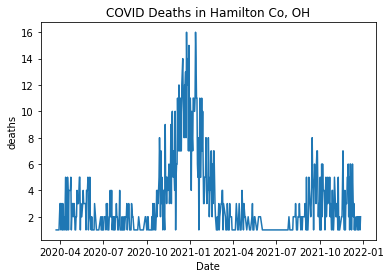

In [181]:
#Let's investigate more by plotting the mortality data
ham_grouped.set_index('Date')

# Draw a line plot of Deaths and Dates
plt.plot(ham_grouped["Date"], ham_grouped["Death Due To Illness Count - County Of Residence"])
plt.xlabel('Date')
plt.ylabel('deaths')

# Create a title
plt.title('COVID Deaths in Hamilton Co, OH')

# Show the plot
plt.show()

It looks like mortality from COVID spiked here around January 2021, fell dramatically in the spring, and increased to a smaller degree by the end of the year.

In [183]:
#let's do something similar with vaccinations
vaccinations=pd.read_csv('vaccine_data.csv')

#get some desription of the contents
vaccinations.info()

#filter to the county where I live
vax_filtered=vaccinations[vaccinations["county"] == 'Hamilton']
vax_filtered.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35100 entries, 0 to 35099
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   county                          35100 non-null  object
 1   date                            35100 non-null  object
 2   vaccines_started                35100 non-null  int64 
 3   vaccines_completed              35100 non-null  int64 
 4   vaccines_first_additional_dose  35100 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.3+ MB


,vaccines_started,vaccines_completed,vaccines_first_additional_dose
count,390.000000,390.000000,390.000000
mean,1328.502564,1220.043590,536.633333
std,1503.741954,1465.688676,992.518907
min,0.000000,0.000000,0.000000
25%,453.250000,368.250000,0.000000
50%,734.500000,608.000000,0.000000
75%,1598.500000,1563.500000,580.250000
max,8468.000000,8865.000000,3602.000000


In [184]:
vax_filtered.loc[vax_filtered["date"].notnull()].min()

county                              Hamilton
date                              2020-12-14
vaccines_started                           0
vaccines_completed                         0
vaccines_first_additional_dose             0
dtype: object

In [185]:
#vax_filtered.head()
vax_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 11700 to 12089
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   county                          390 non-null    object
 1   date                            390 non-null    object
 2   vaccines_started                390 non-null    int64 
 3   vaccines_completed              390 non-null    int64 
 4   vaccines_first_additional_dose  390 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 18.3+ KB


In [186]:
#Let's fix the Date again
vax_filtered['Date'] = pd.to_datetime(vax_filtered['date'])
vax_filtered.drop('date', axis=1, inplace=True)
vax_filtered.head()

<ipython-input-186-06093b7bf8e5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vax_filtered['Date'] = pd.to_datetime(vax_filtered['date'])
/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,county,vaccines_started,vaccines_completed,vaccines_first_additional_dose,Date
11700,Hamilton,9,0,0,2020-12-14
11701,Hamilton,145,0,0,2020-12-15
11702,Hamilton,134,0,0,2020-12-16
11703,Hamilton,184,0,0,2020-12-17
11704,Hamilton,163,0,0,2020-12-18


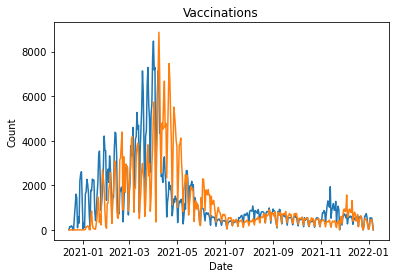

In [188]:
#Let's investigate by plotting Vaccinations started and completed (assuming a 2 dose protocol?)
vax_filtered.set_index('Date')

# Draw a line plot of Vaccinations and Dates
plt.plot(vax_filtered["Date"], vax_filtered["vaccines_started"], label='Vaccines started')
plt.plot(vax_filtered["Date"], vax_filtered["vaccines_completed"], label='Vaccines completed')
plt.xlabel('Date')
plt.ylabel('Count')

# Add a title
plt.title('Vaccinations')

# Show the plot
plt.show()

In [189]:
#Let's join the vaccination and mortality data
vax_and_death_inner = pd.merge(ham_filtered, vax_filtered, how='inner')
vax_and_death_inner.head()
#hmm this might drop records that we want because the dates of vaccinations would potentially impact deaths later.

,County,Sex,Age Range,Onset Date,Admission Date,Date Of Death,Case Count,Hospitalized Count,Death Due To Illness Count - County Of Residence,Date,county,vaccines_started,vaccines_completed,vaccines_first_additional_dose
0,Hamilton,Female,60-69,NaN,NaN,2020-12-14,0,0,1,2020-12-14,Hamilton,9,0,0
1,Hamilton,Female,50-59,NaN,NaN,2020-12-14,0,0,1,2020-12-14,Hamilton,9,0,0
2,Hamilton,Female,70-79,NaN,NaN,2020-12-14,0,0,1,2020-12-14,Hamilton,9,0,0
3,Hamilton,Female,80+,NaN,NaN,2020-12-14,0,0,5,2020-12-14,Hamilton,9,0,0
4,Hamilton,Male,60-69,NaN,NaN,2020-12-14,0,0,2,2020-12-14,Hamilton,9,0,0


In [190]:
#Do a left join from Mortality and filter to a date range where we have consistent data between the two sets.
vax_and_death_left = pd.merge(ham_grouped, vax_filtered, how='left')
vax_and_death_left.head()
vax_and_death_left=vax_and_death_left[vax_and_death_left["Date"]>= '2020-12-14']
vax_and_death_left.head()

,Date,Case Count,Hospitalized Count,Death Due To Illness Count - County Of Residence,county,vaccines_started,vaccines_completed,vaccines_first_additional_dose
210,2020-12-14,0,0,12,Hamilton,9.0,0.0,0.0
211,2020-12-15,0,0,13,Hamilton,145.0,0.0,0.0
212,2020-12-16,0,0,14,Hamilton,134.0,0.0,0.0
213,2020-12-17,0,0,11,Hamilton,184.0,0.0,0.0
214,2020-12-18,0,0,10,Hamilton,163.0,0.0,0.0


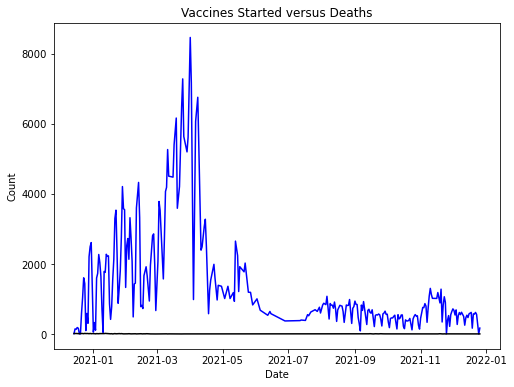

In [108]:
#Let's plot mortality against Vaccinations
vax_filtered.set_index('Date')

# Draw a line plot of Vaccinations and Dates
plt.plot(vax_and_death_left["Date"], vax_and_death_left["vaccines_started"], color="blue", label='Vaccines started')
#plt.plot(vax_and_death_left["Date"], vax_and_death_left["vaccines_completed"], color="green", label='Vaccines completed')
plt.plot(vax_and_death_left["Date"], vax_and_death_left["Death Due To Illness Count - County Of Residence"], color="black", label='Deaths')

plt.xlabel('Date')
plt.ylabel('Count')

# Add a title
plt.title('Vaccines Started versus Deaths')

# Show the plot
plt.show()

That graph isn't meaningful because the scale of the mortality data is (thankfully) so much lower than the vaccination series. Let's try again with multiple Y-axes.

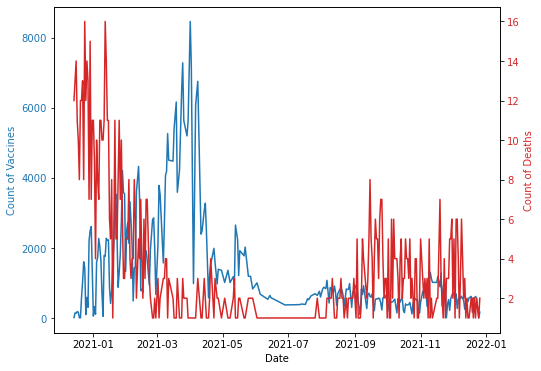

In [128]:
#Built a plot with multiple y axes
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Count of Vaccines', color=color)
ax1.plot(vax_and_death_left["Date"], vax_and_death_left["vaccines_started"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Count of Deaths', color=color)  # we already handled the x-label with ax1
ax2.plot(vax_and_death_left["Date"], vax_and_death_left["Death Due To Illness Count - County Of Residence"], color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.show()

It looks like there's a relationship between deaths and vaccinations - deaths fall in the first half of 2021 as vaccinations rise. By Q4 2021 though, vaccinations have leveled off, and deaths reach what appears to be a new elevated plateau.

In [110]:
#Run some descriptive checks on coorelation
vax_and_death_left.corr(method='pearson')

,Case Count,Hospitalized Count,Death Due To Illness Count - County Of Residence,vaccines_started,vaccines_completed,vaccines_first_additional_dose
Case Count,NaN,NaN,NaN,NaN,NaN,NaN
Hospitalized Count,NaN,NaN,NaN,NaN,NaN,NaN
Death Due To Illness Count - County Of Residence,NaN,NaN,1.000000,-0.076023,-0.243979,-0.178298
vaccines_started,NaN,NaN,-0.076023,1.000000,0.644550,-0.300439
vaccines_completed,NaN,NaN,-0.243979,0.644550,1.000000,-0.251704
vaccines_first_additional_dose,NaN,NaN,-0.178298,-0.300439,-0.251704,1.000000


In [111]:
vax_and_death_left.corr(method='spearman')

,Case Count,Hospitalized Count,Death Due To Illness Count - County Of Residence,vaccines_started,vaccines_completed,vaccines_first_additional_dose
Case Count,NaN,NaN,NaN,NaN,NaN,NaN
Hospitalized Count,NaN,NaN,NaN,NaN,NaN,NaN
Death Due To Illness Count - County Of Residence,NaN,NaN,1.000000,-0.036556,-0.297721,-0.104525
vaccines_started,NaN,NaN,-0.036556,1.000000,0.588124,-0.494471
vaccines_completed,NaN,NaN,-0.297721,0.588124,1.000000,-0.205580
vaccines_first_additional_dose,NaN,NaN,-0.104525,-0.494471,-0.205580,1.000000


In [112]:
scipy.stats.pearsonr(vax_and_death_left["Death Due To Illness Count - County Of Residence"], vax_and_death_left["vaccines_completed"])

(-0.2439791378516385, 4.6125150792641784e-05)

There's something there, but it's not particularly strong. Try and build a model to generalize the effect.

In [130]:
#Simplify things by selecting only the columns that we need for analysis
model_dataset=vax_and_death_left[['Date', 'Death Due To Illness Count - County Of Residence', 'vaccines_completed']]

In [132]:
model_dataset.head()

,Date,Death Due To Illness Count - County Of Residence,vaccines_completed
210,2020-12-14,12,0.0
211,2020-12-15,13,0.0
212,2020-12-16,14,0.0
213,2020-12-17,11,0.0
214,2020-12-18,10,0.0


In [204]:
#Build a quick Autoregressive integrated moving average model. We don't expect to have a simple linear regression here, but let's see what the model predicts for Mortality.

from statsmodels.tsa.arima_model import ARIMA

# 1,1,1 ARIMA Model
#Arima models have 3 parameters:
#p is the order (number of time lags) of the autoregressive model
#d is the degree of differencing
#q is the order of the moving-average model.

model = ARIMA(model_dataset["Death Due To Illness Count - County Of Residence"], order=(5,2,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provide

                                              ARIMA Model Results                                              
Dep. Variable:     D2.Death Due To Illness Count - County Of Residence   No. Observations:                  271
Model:                                                  ARIMA(5, 2, 2)   Log Likelihood                -558.894
Method:                                                        css-mle   S.D. of innovations              1.867
Date:                                                 Sun, 09 Jan 2022   AIC                           1135.788
Time:                                                         18:55:29   BIC                           1168.207
Sample:                                                              2   HQIC                          1148.805
                                                                                                               
                                                                coef    std err          z      P>|z|   

/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:1521: RuntimeWarning: invalid value encountered in sqr

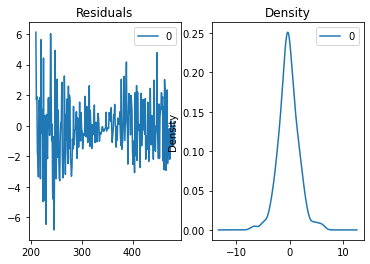

In [202]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

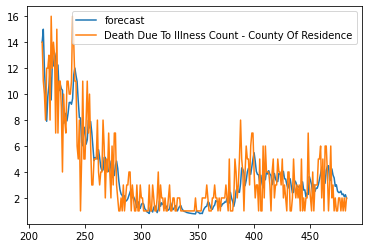

In [205]:
#Plot our predictions
model_fit.plot_predict(dynamic=False)
plt.show()

We could spend more time optimizing our parameters, but it looks like the availability of vaccines continues to drive mortality down, even if the pace of expansion has slowed.